# Notebook 02 - Distributions

*Martin Vonk - 2022*

This notebooks shows an example of choosing the right distribution of the precipitation or precipitation-excess. Note that this notebooks focusses on visually interpreting this data. There are also tests to check the validity of a distribution. However these are not currently implemented in this package.

## Required packages

In [1]:
from calendar import month_name
import spei as si  # si for standardized index
import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt

## Load time series

We use time series from the Netherlands. The precipitation and precipitation-excess (precipitation - potential evaporation) time series are accumulated on with a 30D rolling sum.

<Axes: title={'center': 'Precipitation Excess'}, ylabel='[mm]'>

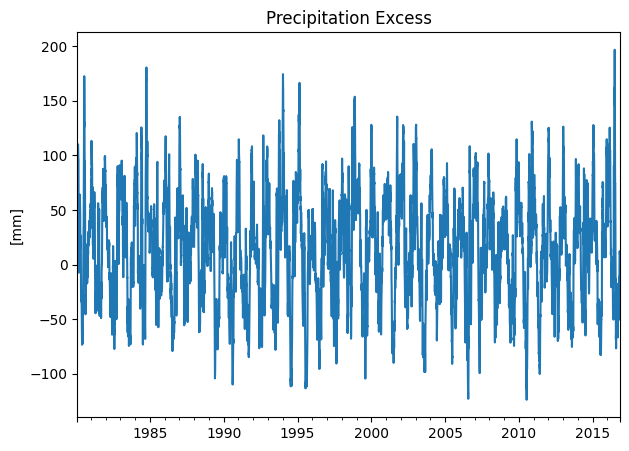

In [2]:
fileurl = "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data"
rain = (
    pd.read_csv(f"{fileurl}/rain_nb1.csv", index_col=0, parse_dates=True)
    .squeeze()
    .multiply(1e3)
)  # to mm
evap = (
    pd.read_csv(f"{fileurl}/evap_nb1.csv", index_col=0, parse_dates=True)
    .squeeze()
    .multiply(1e3)
)  # to mm

# accumulate time series
f = 30
prec = rain.rolling(f"{f}D", min_periods=f).sum().dropna()
pe = (rain - evap).dropna().rolling(f"{f}D", min_periods=f).sum().dropna()
pe.plot(xlabel="", ylabel="[mm]", title="Precipitation Excess", figsize=(7, 5))

## Plot distributions

The internal plot.dist method can be used to plot the (cumulative) histogram and the scipy.stats distribution fit. The given distribution using a [maximum likelihood estimate](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.fit.html#scipy.stats.rv_continuous.fit) where a negative log-likelihood function is minimized. It can be important to visually check if the (cumulative) density function is actually valid for the (cumulative) histogram of the data. Let's first try that for the pearson3 distribution. 

We'll reproduce some steps that are normally done internally. First we group the data per date (index) and year (columns). This way if we can easily group per given frequency on which we want to fit the distribution.

In [3]:
dfval = si.utils.group_yearly_df(series=pe)
dfval

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,NaN,53.4,61.4,73.4,36.1,18.9,60.2,112.2,19.7,58.3,...,58.1,61.5,23.4,77.9,55.0,109.5,124.2,81.2,81.7,34.8
2000-01-02,NaN,56.1,61.7,75.4,42.9,20.9,65.0,124.6,23.7,56.5,...,66.8,49.9,19.7,76.0,52.8,115.5,126.3,82.6,83.7,38.1
2000-01-03,NaN,73.2,66.9,76.5,56.5,23.1,66.6,126.8,29.5,53.3,...,61.9,38.2,19.1,72.9,52.9,112.6,122.4,85.2,84.2,41.4
2000-01-04,NaN,78.4,59.8,83.8,61.8,27.3,70.1,127.3,29.8,47.9,...,59.5,37.1,14.6,68.8,44.2,118.5,118.2,86.5,94.6,56.8
2000-01-05,NaN,72.6,66.9,79.8,63.1,27.7,66.4,125.0,36.8,45.3,...,60.5,39.9,17.3,60.9,41.4,125.3,118.0,83.5,94.4,57.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-27,55.9,81.3,73.9,62.9,13.4,77.3,70.4,16.3,82.5,75.8,...,76.1,30.8,65.0,59.3,99.8,107.7,56.4,79.6,84.2,NaN
2000-12-28,55.0,72.7,74.0,43.3,13.6,70.0,72.7,16.1,83.3,76.2,...,76.1,30.1,65.8,59.8,99.4,119.8,83.6,80.1,82.2,NaN
2000-12-29,51.9,66.7,73.9,35.8,13.4,70.2,74.6,16.1,83.1,77.1,...,76.6,29.8,58.9,59.7,100.5,122.1,84.6,81.1,79.7,NaN


Lets fit the pearson3 distribution

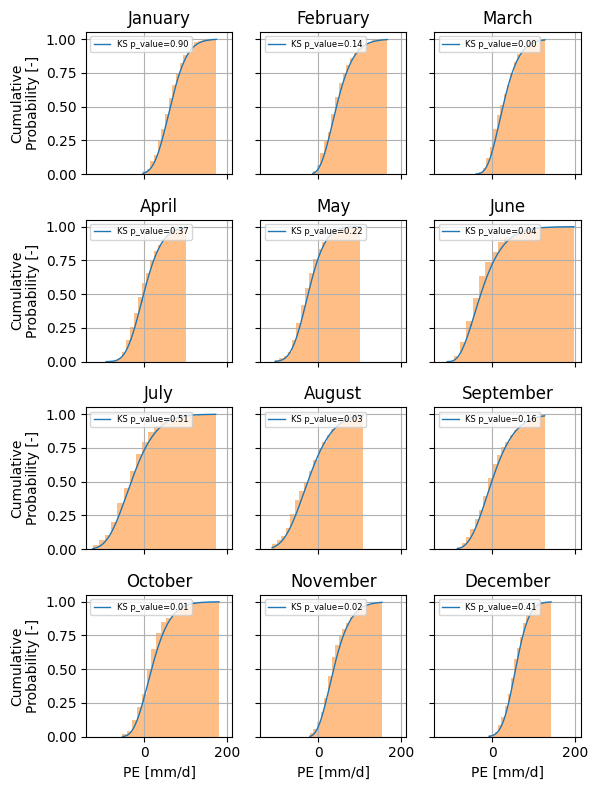

In [4]:
freq = "ME"
dist = scs.pearson3

f, axl = plt.subplots(4, 3, figsize=(6, 8), sharey=True, sharex=True)
axsr = axl.ravel()
for date, grval in dfval.groupby(pd.Grouper(freq=freq)):
    data = si.utils.get_data_series(grval).sort_values()
    fd = si.dist.FittedDist(data=data, dist=dist)
    cdf = fd.cdf()
    p_value = fd.ks_test()
    axsr[date.month - 1].plot(
        data.values, cdf.values, color="C0", linewidth=1, label=f"KS {p_value=:0.2f}"
    )
    axsr[date.month - 1].hist(
        data.values,
        alpha=0.5,
        density=True,
        cumulative=True,
        bins=20,
        color="C1",
    )
    axsr[date.month - 1].set_title(month_name[date.month])
    axsr[date.month - 1].grid(True)
    axsr[date.month - 1].legend(loc=2, fontsize=6)

[ax.set_ylabel("Cumulative\nProbability [-]") for ax in axl[:, 0]]
[ax.set_xlabel("PE [mm/d]") for ax in axl[-1, :]]
f.tight_layout()

The blue plotted line is the fitted pearson3 distribution and the orange fill is the cumulative histogram. For the fitted distributions seem to describe the precipitation excess values pretty well. The legend shows the p_value of the two-sided        Kolmogorov-Smirnov test for goodness of fit. The null hypothesis two-sided test is that the two distributions are identical, the alternative is that they are not identical. Say we choose a confidence level of 95%; that is, we will reject the null hypothesis in favor of the alternative if the p-value is less than 0.05. For e.g. march the p-value is lower than our threshold of 0.05, so we reject the null hypothesis in favor of the default “two-sided” alternative: the data are not distributed according to the fitted pearson3 distribution. But not finding the appropriate distribution is one of the big uncertainties of the standardized index method. However, not a perfect fit does not mean this distribution is not fit-for-purpose of calculating a drought index. That is up to the modeller to decide. 

We could try to fit another distribution, e.g. Fisk. Let's plot the probability density function instead of the cdf to get more insight.

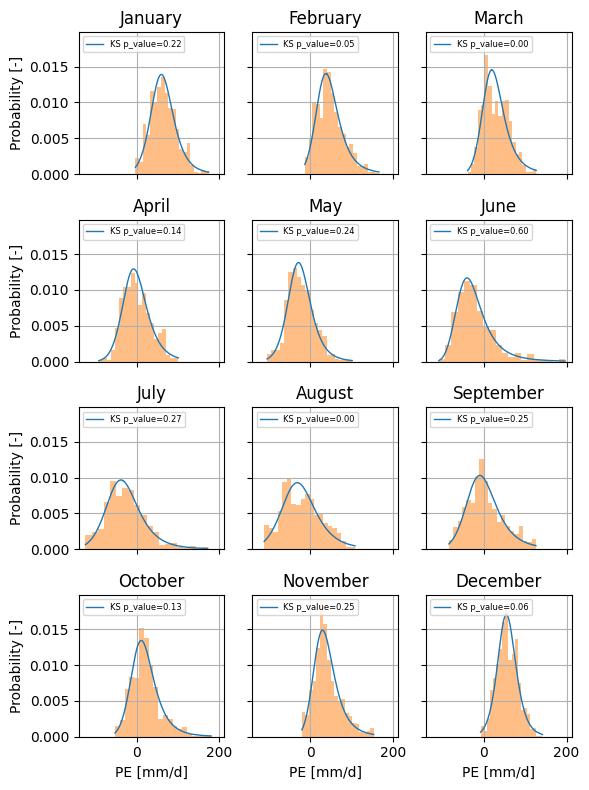

In [5]:
freq = "ME"
dist = scs.fisk

f, axl = plt.subplots(4, 3, figsize=(6, 8), sharey=True, sharex=True)
axsr = axl.ravel()
for date, grval in dfval.groupby(pd.Grouper(freq=freq)):
    data = si.utils.get_data_series(grval).sort_values()
    fd = si.dist.FittedDist(data=data, dist=dist)
    pdf = fd.pdf()
    p_value = fd.ks_test()
    axsr[date.month - 1].plot(
        data.values, pdf.values, color="C0", linewidth=1, label=f"KS {p_value=:0.2f}"
    )
    axsr[date.month - 1].hist(
        data.values,
        alpha=0.5,
        density=True,
        cumulative=False,
        bins=20,
        color="C1",
    )
    axsr[date.month - 1].set_title(month_name[date.month])
    axsr[date.month - 1].grid(True)
    axsr[date.month - 1].legend(loc=2, fontsize=6)

[ax.set_ylabel("Probability [-]") for ax in axl[:, 0]]
[ax.set_xlabel("PE [mm/d]") for ax in axl[-1, :]]
f.tight_layout()

We can now see more cleary that there is a discrepancy between the data and the fitted distribution. However, the p_value is only less than 0.05 for march and august for the fisk distribution. For the pearson3 this was also the case for june, october and november. So the fisk distribution seems better in for this precipitation excess series than the pearson3 distribution.

## Window fitting

When the frequency of the original time series is higher than the fit frequncy, edge effects can occor. For instance if the frequency of the series is daily, but a distribution is fitted per month jumps can occur between the last and first day a new month. To prevent this the user can choose to fit a distribution on the frequency of the time series. However, fitting distributions per day gives less data per distribution to fit, sometimes resulting in a bad fit of the distribution. An example:

In [6]:
spi_d = si.spi(pe, dist=scs.gamma, freq="D")

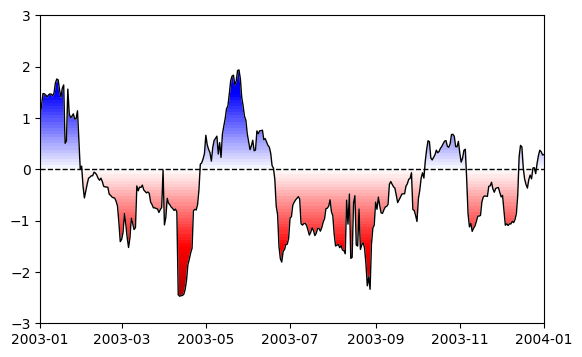

In [7]:
ax = si.plot.si(spi_d, ybound=3)
ax.set_xlim(pd.Timestamp("2003-01-01"), pd.Timestamp("2004-01-01"));

As can be seen in the figure sharp peaks are visible in the SPI, e.g. in august. To get a better fit of the distribution on those days, one can try to take into account days as well. After all, it is quite logical to take into account the distribution of the 1st of august and 3rd of august when determining the distribution for the 2nd of august. Note that this does not mean the distribution is summed over a larger window. Just more data is taken into account to determine the distribution for the specific day / week. The window argument provides for this:

In [8]:
spi_3d = si.spi(pe, dist=scs.gamma, freq="D", window=3)

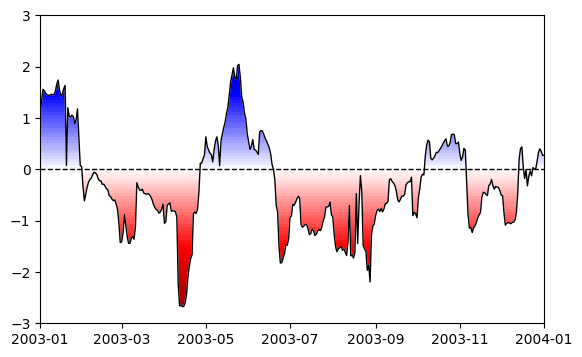

In [9]:
ax = si.plot.si(spi_3d, ybound=3)
ax.set_xlim(pd.Timestamp("2003-01-01"), pd.Timestamp("2004-01-01"));

As you can see the sudden peaks are a lot less sharp but some are still visible. Therefore it might be appropriate to choose a larger window. 